(metric_analysis)=
# Metric Analysis

This vignette demonstrates a more complete use of FlexEval: constructing an {class}`~flexeval.schema.eval_schema.Eval` with both rubric and function metrics, running that eval via an {class}`~flexeval.schema.evalrun_schema.EvalRun`, and using FlexEval utility functions to retrieve and interpret the results.

Author: [Zachary Levonian](https://levon003.github.io) \
Date: July 2025

## Part 1: Running FlexEval to compute metrics

We'll create some test data, build an eval, and execute it.

In [1]:
import dotenv

assert dotenv.load_dotenv("../.env"), (
    "This vignette assumes access to API keys in a .env file."
)

### Generating test data

Let's evaluate the quality of grade-appropriate explanations.

In [2]:
concepts = ["integer addition", "factoring polynomials", "logistic regression"]
grades = ["3rd", "5th", "7th", "9th"]

user_queries = []
for concept in concepts:
    for grade in grades:
        user_queries.append(
            f"Concisely summarize {concept} at the United States {grade}-grade level."
        )
len(user_queries)

12

We can imagine that our system under test involves a particular system prompt, or perhaps multiple candidate prompts.

In this case, we'll imagine a single, simple system prompt.

In [3]:
system_prompt = """You are a friendly math tutor.

You attempt to summarize any mathematical topic the student is interested in, even if it's not appropriate for their grade level."""

In [4]:
# convert to JSONL
import json
from pathlib import Path

concept_queries_path = Path("concept_queries.jsonl")
with open(concept_queries_path, "w") as outfile:
    for user_query in user_queries:
        outfile.write(
            json.dumps(
                {
                    "input": [
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": user_query},
                    ]
                }
            )
            + "\n"
        )

Each line of `concept_queries.jsonl` will become a unique {class}`~flexeval.classes.thread.Thread` to be processed.

Now that we have test data, we can build a FlexEval configuration and execute it.

### Defining an Eval

An {class}`~flexeval.schema.eval_schema.Eval` describes the computations that need to happen to compute the required metrics.

In this case, we'll set a few details:
 - We want to generate new LLM completions, rather than just using any existing assistant messages in our threads. To do that, we'll set {attr}`~flexeval.schema.eval_schema.Eval.do_completion` to true, and define the function to actually generate those completions from those provided in {mod}`flexeval.configuration.completion_functions`. In this case, we'll use {func}`~flexeval.configuration.completion_functions.litellm_completion`, which uses [LiteLLM](https://docs.litellm.ai) to provide access to many different model APIs.
 - We'll compute two {class}`~flexeval.schema.eval_schema.FunctionItem`s, a [Flesch reading ease](https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests) score and {meth}`~flexeval.configuration.function_metrics.is_role`. We need `is_role` because we can use its value to compute particular metrics only for assistant messages (like the new completions we'll be generating).
 - Finally, we can specify a custom {class}`~flexeval.schema.eval_schema.RubricItem`s. We'll write a prompt that describes the assessment we want to make. In this case, we try to determine if the assistant response is grade appropriate.

In [5]:
import flexeval
from flexeval.schema import (
    Eval,
    Rubric,
    GraderLlm,
    DependsOnItem,
    Metrics,
    FunctionItem,
    RubricItem,
    CompletionLlm,
)

In [6]:
# by specifying an OpenAI model name here, we'll need OPENAI_API_KEY to exist in our environment variables or in our .env file
completion_llm = CompletionLlm(
    function_name="litellm_completion",
    kwargs={"model": "gpt-4o-mini"},
)

A note about {class}`~flexeval.schema.eval_schema.CompletionLlm`: if you're using LiteLLM, you can replace an API call with a pre-written response by passing `mock_response` as an additional keyword argument.

For example, this configuration will always return "I can't help with that!":

```python
kwargs={"model": "gpt-4o-mini", "mock_response": "I can't help with that!"}
```

Now let's define a rubric. We just need a prompt, a set of choice scores mapping from string responses to a numeric metric value, and information about what LLM to use. For simplicity, we'll use the same model for evaluating the completions that we use to generate them – but this should probably be avoided in general due to LLMs' [preference for their own outputs](https://arxiv.org/abs/2404.13076).

In [7]:
bad_rubric_prompt = """Read the following input and output, assessing if the output is grade-appropriate.
[Input]: {context}
[Output]: {content}

On a new line after your explanation, print:
- YES if the Output is fully appropriate for the grade level
- NO if the Output would uses language or concepts that would be inappropriate for that grade level

Only print YES or NO on the final line.
"""
rubric = Rubric(
    prompt=bad_rubric_prompt,
    choice_scores={"YES": 1, "NO": 0},
)
rubrics = {
    "is_grade_appropriate": rubric,
}
grader_llm = GraderLlm(
    function_name="litellm_completion", kwargs={"model": "gpt-4o-mini"}
)

We'll define the metrics that need to be computed using the rubric name defined above (`is_grade_appropriate`).

We'll also define the computation of our two function metrics: {meth}`~flexeval.configuration.function_metrics.is_role` and {meth}`~flexeval.configuration.function_metrics.flesch_reading_ease`.

We want to evaluate `flesch_reading_ease` and `is_grade_appropriate` only on assistant turns, so we need to declare a dependency.

Here's how we declare a dependency:

 - A {class}`~flexeval.schema.eval_schema.DependsOnItem` requires a `name` that matches a defined metric.
 - Providng `kwargs` are optional, but if you use the same name with different kwargs you need to provide them so that we know which metric you're depending on.
 - Set `metric_min_value` or `metric_max_value` or both. The {meth}`~flexeval.configuration.function_metrics.is_role` documentation tell us that it returns 1 (true) if the turn has the role provided in the keyword args and 0 (false) otherwise. So we just need to set `metric_min_value` to 1.
 - When we define a {class}`~flexeval.schema.eval_schema.MetricItem` that has dependencies, provide one or more {class}`~flexeval.schema.eval_schema.DependsOnItem`s in the {attr}`~flexeval.schema.eval_schema.MetricItem.depends_on` list.

In [8]:
is_assistant_dependency = DependsOnItem(
    name="is_role", kwargs={"role": "assistant"}, metric_min_value=1
)
metrics = Metrics(
    function=[
        FunctionItem(name="is_role", kwargs={"role": "assistant"}),
        FunctionItem(
            name="flesch_reading_ease",
            depends_on=[is_assistant_dependency],
        ),
    ],
    rubric=[
        RubricItem(name="is_grade_appropriate", depends_on=[is_assistant_dependency])
    ],
)

We'll finish building our {class}`~flexeval.schema.eval_schema.Eval` by providing all the info we defined above.

An eval's `name` is optional, but providing one can help you later if you're running lots of different Evals against the same dataset.

I'll call this eval `grade_appropriateness`, since that's what we're trying to evaluate.

In [9]:
eval = Eval(
    name="grade_appropriateness",
    metrics=metrics,
    grader_llm=grader_llm,
    do_completion=True,
    completion_llm=completion_llm,
)
eval

Eval(do_completion=True, name='grade_appropriateness', notes='', metrics=Metrics(function=[FunctionItem(name='is_role', depends_on=[], metric_level='Turn', kwargs={'role': 'assistant'}), FunctionItem(name='flesch_reading_ease', depends_on=[DependsOnItem(name='is_role', type=None, kwargs={'role': 'assistant'}, metric_name=None, metric_level=None, relative_object_position=0, metric_min_value=1.0, metric_max_value=1.7976931348623157e+308)], metric_level='Turn', kwargs={})], rubric=[RubricItem(name='is_grade_appropriate', depends_on=[DependsOnItem(name='is_role', type=None, kwargs={'role': 'assistant'}, metric_name=None, metric_level=None, relative_object_position=0, metric_min_value=1.0, metric_max_value=1.7976931348623157e+308)], metric_level='Turn', kwargs={})]), completion_llm=CompletionLlm(function_name='litellm_completion', include_system_prompt=True, kwargs={'model': 'gpt-4o-mini'}), grader_llm=GraderLlm(function_name='litellm_completion', kwargs={'model': 'gpt-4o-mini'}))

### Building an EvalRun

To execute the defined {class}`~flexeval.schema.eval_schema.Eval`, we need to build an {class}`~flexeval.schema.evalrun_schema.EvalRun`.

Here's what we need (other than the {class}`~flexeval.schema.eval_schema.Eval`):
 - {attr}`~flexeval.schema.evalrun_schema.EvalRun.data_sources` should be a list of datasets. We already saved a jsonl with our inputs, so we'll wrap the path in a {class}`~flexeval.schema.evalrun_schema.FileDataSource`.
 - {attr}`~flexeval.schema.evalrun_schema.EvalRun.database_path` defines the location of the SQLite file that FlexEval produces.
 - {attr}`~flexeval.schema.evalrun_schema.EvalRun.rubric_paths` is where we provide the rubric prompts we defined above (in the form of a {class}`~flexeval.schema.rubric_schema.RubricsCollection`).
 - {attr}`~flexeval.schema.evalrun_schema.EvalRun.config` is optional, but you can provide a {class}`~flexeval.schema.config_schema.Config` there to override settings that define how the Eval will be executed. In this case, we set `clear_tables` to True in order to delete any outputs in the provided `database_path`.

In [10]:
from flexeval.schema import Config, EvalRun, FileDataSource, RubricsCollection

In [11]:
input_data_sources = [FileDataSource(path=concept_queries_path)]
database_path = Path("eval_results.db")
config = Config(clear_tables=True)
eval_run = EvalRun(
    data_sources=input_data_sources,
    database_path=database_path,
    eval=eval,
    config=config,
    rubric_paths=[RubricsCollection(rubrics=rubrics)],
)
eval_run

EvalRun(data_sources=[FileDataSource(name=None, notes=None, path=PosixPath('concept_queries.jsonl'), format='jsonl')], database_path=PosixPath('eval_results.db'), eval=Eval(do_completion=True, name='grade_appropriateness', notes='', metrics=Metrics(function=[FunctionItem(name='is_role', depends_on=[], metric_level='Turn', kwargs={'role': 'assistant'}), FunctionItem(name='flesch_reading_ease', depends_on=[DependsOnItem(name='is_role', type=None, kwargs={'role': 'assistant'}, metric_name=None, metric_level=None, relative_object_position=0, metric_min_value=1.0, metric_max_value=1.7976931348623157e+308)], metric_level='Turn', kwargs={})], rubric=[RubricItem(name='is_grade_appropriate', depends_on=[DependsOnItem(name='is_role', type=None, kwargs={'role': 'assistant'}, metric_name=None, metric_level=None, relative_object_position=0, metric_min_value=1.0, metric_max_value=1.7976931348623157e+308)], metric_level='Turn', kwargs={})]), completion_llm=CompletionLlm(function_name='litellm_complet

### Running the EvalRun

Once we've built an {class}`~flexeval.schema.evalrun_schema.EvalRun`, running it is easy: we can just use {func}`~flexeval.runner.run`!

In [11]:
_ = flexeval.run(eval_run)

Now that we've run our Eval, we can analyze our results!

## Part 2: Analyzing our results

We'll analyze the data we created in Part 1.

### flexeval.metrics.access

A few utility functions are exposed in {mod}`flexeval.metrics.access` for returning computed metrics.

In [13]:
from pathlib import Path

import pandas as pd
from IPython import display  # for prettier printing

from flexeval import db_utils
from flexeval.metrics import access as metric_access

Note: We use Peewee's database methods to access the output at {attr}`~flexeval.schema.evalrun_schema.EvalRun.database_path`. Using {func}`~flexeval.runner.run` will set the appropriate variables for you, but if you just want to access the data from an eval you can use {func}`flexeval.db_utils.ensure_database` to ensure the Peewee connection is available.

In [14]:
database_path = Path("eval_results.db")
db_utils.ensure_database(database_path)

To start, let's just get all of the metrics as a Pandas dataframe. 

{func}`~flexeval.metrics.access.get_all_metrics` returns a list of dictionaries.

In [15]:
df = pd.DataFrame(metric_access.get_all_metrics())
df.head(n=3)

,id,evalsetrun,dataset,thread,turn,message,toolcall,evaluation_name,evaluation_type,metric_name,...,metric_value,kwargs,source,depends_on,rubric_prompt,rubric_completion,rubric_model,rubric_completion_tokens,rubric_prompt_tokens,rubric_score
0,1,1,1,1,1,None,None,is_role,function,assistant,...,0.000000,{'role': 'assistant'},"def is_role(object: Union[Turn, Message], role...",[],None,None,None,NaN,NaN,None
1,2,1,1,1,13,None,None,is_role,function,assistant,...,1.000000,{'role': 'assistant'},"def is_role(object: Union[Turn, Message], role...",[],None,None,None,NaN,NaN,None
2,3,1,1,1,13,None,None,flesch_reading_ease,function,flesch_reading_ease,...,76.191959,{},def flesch_reading_ease(turn: str) -> float:\n...,"[{""name"": ""is_role"", ""type"": null, ""kwargs"": {...",None,None,None,NaN,NaN,None


We have access to all of the columns in {class}`~flexeval.classes.metric.Metric`.

We can see that FlexEval generates one metric result each time it runs, along with information about what was run. Let's look at the columns we have for our metrics.

In [16]:
display.Markdown("Columns returned by `get_all_metrics()`: " + ", ".join(df.columns))

Columns returned by `get_all_metrics()`: id, evalsetrun, dataset, thread, turn, message, toolcall, evaluation_name, evaluation_type, metric_name, metric_level, metric_value, kwargs, source, depends_on, rubric_prompt, rubric_completion, rubric_model, rubric_completion_tokens, rubric_prompt_tokens, rubric_score

Let's start by looking at how many times each metric was computed:

In [17]:
pd.DataFrame(df.evaluation_name.value_counts())

,count
evaluation_name,
is_role,24
flesch_reading_ease,12
is_grade_appropriate,12


These counts look right:
 - Our dataset contained 12 input sentences.
 - We generated 12 LLM responses.
 - `is_role` was evaluated on all 24 turns...
 - ...but `flesch_reading_ease` and `is_grade_appropriate` were computed only on the 12 LLM-generated ("assistant") turns.

Let's start our analysis by looking at the numeric metric: Flesch reading ease.

### Analyzing a function metric

A quick aside: Flesch reading ease is widely used, but it should be used with care. As summarized by Crossley et al. ([CLEAR 2022](https://link.springer.com/article/10.3758/s13428-022-01802-x)): 

>Traditional readability formulas lack construct and theoretical validity because they are based on weak proxies of word decoding (i.e., characters or syllables per word) and syntactic complexity (i.e., number or words per sentence) and ignore many text features that are important components of reading models including text cohesion and semantics. Additionally, many traditional readability formulas were normed using readers from specific age groups on small corpora of texts taken from specific domains.

Nevertheless, many people may expect to see a readability score, and it can be useful to assess the [convergent validity](https://en.wikipedia.org/wiki/Convergent_validity) for some rubric metrics.

Let's start by filtering to only the `flesch_reading_ease` metric results and computing the mean.

In [18]:
flesch_reading_ease = df[df.metric_name == "flesch_reading_ease"]
print(f"Mean Flesch reading ease score: {flesch_reading_ease.metric_value.mean():.2f}")

Mean Flesch reading ease score: 59.89


A Flesch reading ease of 60 is at the ["10th to 12th grade" level](https://pages.stern.nyu.edu/wstarbuc/Writing/Flesch.htm).

Hmm, seems a bit high. 

Plotting the distribution, we never seem to get above 80 (appropriate for 6th grade and lower).

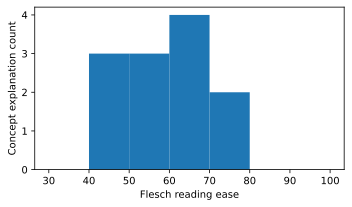

In [20]:
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'

fig, ax = plt.subplots(1, 1, figsize=(5, 3))

ax.hist(flesch_reading_ease.metric_value, bins=np.arange(30, 110, 10))
ax.set_xlabel("Flesch reading ease")
ax.set_ylabel("Concept explanation count")

fig.tight_layout()
plt.show()

Already, we've learned enough to consider going back to our prompt engineering to produce more age-appropriate messages.

But presuming we're okay with the overall range, we'd prefer to see how things are looking at the original grade ranges we were targeting.

We can extract the original grade from the initial user message in each thread in our dataset. 
To get those user messages, we can use another utility function in {mod}`flexeval.metrics.access`.

In [21]:
thread_ids = set(flesch_reading_ease.thread)
# get the first message in each thread
first_message_df = pd.DataFrame(
    metric_access.get_first_user_message_for_threads(thread_ids)
)
# join in the first message texts as "first_message_content"
flesch_reading_ease = flesch_reading_ease.merge(
    first_message_df[["thread", "content"]].rename(
        columns={"content": "first_message_content"}
    ),
    how="inner",
    on="thread",
)
# extract grade level from the messages
flesch_reading_ease["grade_level"] = (
    flesch_reading_ease.first_message_content.str.extract(
        r"(\d+)(?:st|nd|rd|th)-grade"
    ).astype(int)
)
pd.DataFrame(flesch_reading_ease.grade_level.value_counts())

,count
grade_level,
3,3
5,3
7,3
9,3


With grade level in hand, we can investigate reading ease at each prompted grade level.

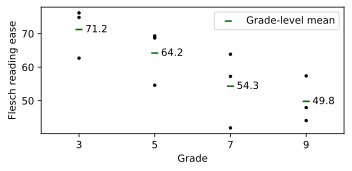

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5))

# no has ever accused matplotlib of being concise
ax.scatter(
    flesch_reading_ease.grade_level,
    flesch_reading_ease.metric_value,
    color="black",
    s=6,
)
means = flesch_reading_ease.groupby("grade_level").metric_value.mean()
ax.scatter(
    means.index, means, color="darkgreen", s=50, marker="_", label="Grade-level mean"
)
for x, y in zip(means.index, means):
    ax.text(x, y, f"  {y:.1f}", va="center", ha="left")
ax.set_xticks(sorted(means.index))
ax.set_xlim(means.index.min() - 1, means.index.max() + 1)
ax.legend()
ax.set_xlabel("Grade")
ax.set_ylabel("Flesch reading ease")

fig.tight_layout()
plt.show()

These group-level means suggest that the completions _are_ more grade-appropriate depending on the prompted grade.

However, the reading ease scores also suggest the responses are potentially too complex.

Even the most readable explanations – generated for the third-grade prompt – are at the 7th-grade level by the Flesch-Kincaid at the 7th-grade level.

### Analyzing a rubric metric

We might attempt to go deeper by investigating the LLM-as-a-judge rubric results.

One of the advantages of a rubric is that we can develop it iteratively.
The investigation here is only an initial look; in reality, we would likely update the prompt after investigating the outputs and seeing where we might sharpen the validity of the metric we're developing.

Let's start by looking at the raw counts.

In [23]:
is_grade_appropriate = df[df.metric_name == "is_grade_appropriate"]
pd.DataFrame(is_grade_appropriate.metric_value.value_counts())

,count
metric_value,
1.0,11
0.0,1


Only one determination of grade inappriateness! Let's try to get some insight by looking at one of the YES determinations.

In [24]:
def quote_markdown(markdown_string: str) -> str:
    return "\n".join("> " + line for line in markdown_string.splitlines())


def format_rubric_summary(rubric_metric) -> str:
    return f"""Prompt:
{quote_markdown(rubric_metric.rubric_prompt)}

Completion:
{quote_markdown(rubric_metric.rubric_completion)}

Parsed response: {rubric_metric.metric_value} ({rubric_metric.rubric_score})"""


rubric_metric = (
    is_grade_appropriate[is_grade_appropriate.metric_value == 1].sample(n=1).iloc[0]
)
display.Markdown(format_rubric_summary(rubric_metric))

Prompt:
> Read the following input and output, assessing if the output is grade-appropriate.
> [Input]: user: Concisely summarize integer addition at the United States 5th-grade level.
> 
> [Output]: assistant: Integer addition involves combining whole numbers to find a total. To add integers, start with the first number and count up by the second number. Here are some key points:
> 
> 1. **Positive Integers**: When you add two positive numbers, you simply find their total (e.g., 3 + 4 = 7).
> 2. **Negative Integers**: When adding negative numbers, you find the total by moving left on the number line (e.g., -3 + -4 = -7).
> 3. **Mix of Positive and Negative**: If you add a positive and a negative number, subtract the smaller absolute value from the larger one, and keep the sign of the number with the larger absolute value (e.g., 5 + -3 = 2 and -5 + 3 = -2).
> 
> Practice adding integers using number lines or counters to see how it works!
> 
> 
> On a new line after your explanation, print:
> - YES if the Output is fully appropriate for the grade level
> - NO if the Output would uses language or concepts that would be inappropriate for that grade level
> 
> Only print YES or NO on the final line.

Completion:
> 1. The input asks for a concise summary of integer addition suitable for a 5th-grade level.
> 2. The output begins by clearly defining integer addition in simple terms, "combining whole numbers to find a total," which is age-appropriate.
> 3. The output includes basic concepts of addition - explaining how to add positive integers, which is straightforward and suitable for 5th graders.
> 4. The output then covers negative integers, explaining their addition in a manner that relates to the number line, which may be complex but is part of the 5th-grade curriculum and is explained clearly.
> 5. The section on mixing positive and negative integers is also relevant and explained through examples, making it easier for students to understand.
> 6. The suggestion to practice with number lines or counters reinforces learning, which is valuable for elementary students.
> 
> Overall, the language and concepts used in the output are appropriate for the 5th-grade level, offering explanations and examples that are clear and relatable.
> 
> Based on this reasoning, I conclude that the output is indeed grade-appropriate.
> 
> YES
> YES

Parsed response: 1.0 (YES)

Hmm, not quite convincing. I already have a few ideas for how we might improve our prompt.

Let's finish up by looking at the one No determination.

In [25]:
rubric_metric = (
    is_grade_appropriate[is_grade_appropriate.metric_value == 0].sample(n=1).iloc[0]
)
display.Markdown(format_rubric_summary(rubric_metric))

Prompt:
> Read the following input and output, assessing if the output is grade-appropriate.
> [Input]: user: Concisely summarize factoring polynomials at the United States 3rd-grade level.
> 
> [Output]: assistant: Factoring polynomials means breaking them down into simpler parts that, when multiplied together, give you the original polynomial. Think of it like taking a number apart into its smaller number pieces. For example, if you have \( x^2 + 2x \), you can factor it by pulling out a common piece, which in this case is \( x \). So, it becomes \( x(x + 2) \). This makes it easier to work with!
> 
> 
> On a new line after your explanation, print:
> - YES if the Output is fully appropriate for the grade level
> - NO if the Output would uses language or concepts that would be inappropriate for that grade level
> 
> Only print YES or NO on the final line.

Completion:
> 1. **Understanding the Input**: The user is asking for a summary of factoring polynomials suitable for a 3rd-grade level. This means the explanation needs to be simple, using language that is easily understandable by young children.
> 
> 2. **Analyzing the Output**: The output explains that factoring polynomials involves breaking them down into simpler parts. It uses the example of \( x^2 + 2x \) and shows how to factor it into \( x(x + 2) \).
> 
> 3. **Evaluating Language and Concepts**:
>    - "Factoring polynomials" may be too advanced for a 3rd grader, who is typically learning basic operations with numbers and simple algebraic concepts.
>    - The terminology could be challenging. Phrases like "breaking them down into simpler parts" and "when multiplied together" might be difficult for 3rd graders to grasp fully.
>    - The example provided uses variables, which might also be unfamiliar to 3rd graders who may not yet have been introduced to algebraic expressions.
> 
> 4. **Conclusion**: Overall, while the concept of breaking things down is appropriate, the specific language and the variable example make it likely outside the understanding of typical 3rd graders. 
> 
> Therefore, the output is not fully appropriate for the grade level of a 3rd grader.
> 
> Based on this reasoning, I will provide the final answer.
> 
> NO
> 
> NO

Parsed response: 0.0 (NO)

This analysis looks better, but still quite vague. I see many specifics that we could include in the prompt as examples!

### Next steps

Based on this analysis, I would:
 - Update the completion prompt to produce more appropriate responses.
 - Update the rubric prompt to make more accurate – and harsher! – determinations about the appropriateness of the langauge used.